## Forecasting Energy Output

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
df = pd.read_csv('../data/interim/filled_for_forecasting.csv', index_col = 0, parse_dates = True)

In [3]:
df.columns

Index(['Shark Meter, KWtotal Kilowatts', 'AE 500kW 1, AC Power Kilowatts',
       'AE 500kW 2, AC Power Kilowatts',
       '(Offline) Weather Station - POA (POA)* Watts/meter²',
       'RECx31 Weather Station, Module Temp Degrees Celsius',
       'RECx31 Weather Station, Ambient Temp Degrees Celsius',
       'AE 500kW 1, PV current Amps', 'AE 500kW 2, PV current Amps',
       'AE 500kW 1, PV voltage Volts', 'AE 500kW 2, PV voltage Volts'],
      dtype='object')

In [4]:
df.index

DatetimeIndex(['2015-10-01 00:00:00', '2015-10-01 00:15:00',
               '2015-10-01 00:30:00', '2015-10-01 00:45:00',
               '2015-10-01 01:00:00', '2015-10-01 01:15:00',
               '2015-10-01 01:30:00', '2015-10-01 01:45:00',
               '2015-10-01 02:00:00', '2015-10-01 02:15:00',
               ...
               '2020-12-31 21:30:00', '2020-12-31 21:45:00',
               '2020-12-31 22:00:00', '2020-12-31 22:15:00',
               '2020-12-31 22:30:00', '2020-12-31 22:45:00',
               '2020-12-31 23:00:00', '2020-12-31 23:15:00',
               '2020-12-31 23:30:00', '2020-12-31 23:45:00'],
              dtype='datetime64[ns]', name='Site Time', length=184224, freq=None)

We're going to forecast energy output, so let's calcuate that on an hourly basis by summing the average power.  

In [5]:
energy_hourly = df[['Shark Meter, KWtotal Kilowatts']].resample('H').sum()*.25

In [6]:
decomp = seasonal_decompose(energy_hourly, period=24*365, model = 'add')

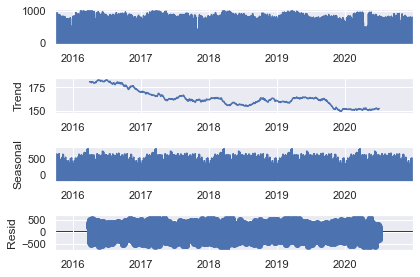

In [7]:
decomp.plot();

It's really hard to see the seasonality here because the data is so noisy, so let's try this again with a rolling average.  

In [8]:
energy_hourly_rolling_7D = energy_hourly.rolling(window='7D').mean()

In [9]:
decomp = seasonal_decompose(energy_hourly_rolling_7D, period=24*365, model = 'add')

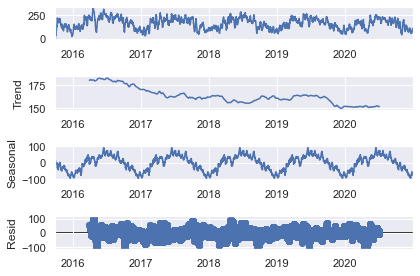

In [10]:
decomp.plot();

Now we clearly see the seasonality, the downward trend as the solar cells degrade.  We also see that the residuals are still quite large.  

In [11]:
# Let's use pre-2020 data as training data and 2020 data as test data
train = energy_hourly_rolling_7D .loc[:'2020-01-01']
test = energy_hourly_rolling_7D .loc['2020-01-01':]

### Holt-Winters Method

In [12]:
train.head()

,"Shark Meter, KWtotal Kilowatts"
Site Time,
2015-10-01 00:00:00,0.0
2015-10-01 01:00:00,0.0
2015-10-01 02:00:00,0.0
2015-10-01 03:00:00,0.0
2015-10-01 04:00:00,0.0


In [13]:
import warnings
warnings.filterwarnings("ignore")

In [14]:
HW_model = ExponentialSmoothing(train,trend='add',seasonal='add',seasonal_periods=24*365).fit()

In [15]:
start=len(train)
end=len(train)+len(test)-1
HW_preds = HW_model.predict(start=start, end=end).rename('HW Predictions')

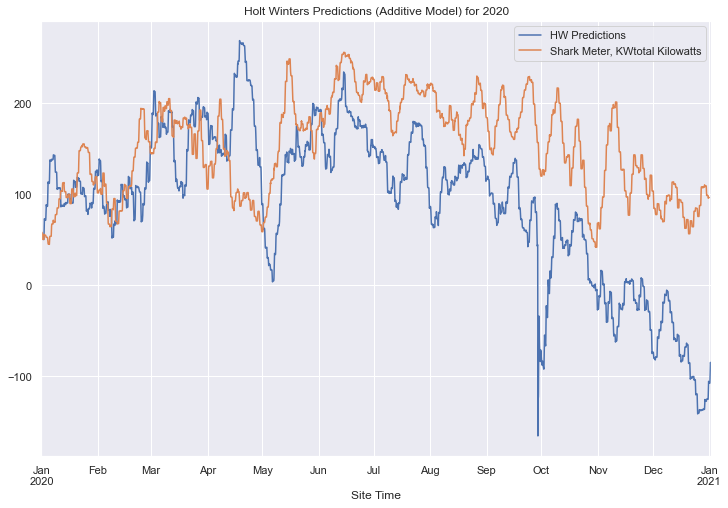

In [16]:
ax = HW_preds.plot(figsize=(12,8),legend=True)
test.plot(ax=ax, legend=True);
plt.title('Holt Winters Predictions (Additive Model) for 2020');

In [17]:
mae = mean_absolute_error(test, HW_preds)
print(f'MAE Error: {mae:11.10}')
rmse = np.sqrt(mean_squared_error(test, HW_preds))
print(f'RMSE Error: {rmse:11.10}')

MAE Error: 79.86297038
RMSE Error: 98.05321046


### SARIMAX

In [18]:
energy_hourly_rolling_7D.shape

(46056, 1)

In [19]:
# auto_arima is not returning so let's try with daily data
energy_daily = energy_hourly_rolling_7D.resample('D').mean()

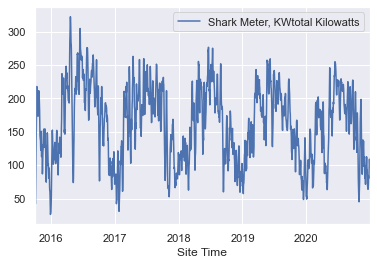

In [20]:
energy_daily.plot();

In [21]:
temp = energy_daily.loc['2019':'2020']

In [22]:
temp.shape

(731, 1)

In [23]:
#Get best parameters from auto_arima

stepwise_fit = auto_arima(temp, 
                            m=365,
                            seasonal=True,
                            trace=True,
                            maxiter = 10,
                      #      error_action='ignore',   # we don't want to know if an order does not work
                            suppress_warnings=False,  # we don't want convergence warnings
                            stepwise=True)           # set to stepwise

stepwise_fit.summary()

Performing stepwise search to minimize aic


KeyboardInterrupt: 

In [24]:
# Let's try with monthly data
energy_monthly = energy_hourly_rolling_7D.resample('M').mean()

In [25]:
energy_monthly.shape

(63, 1)

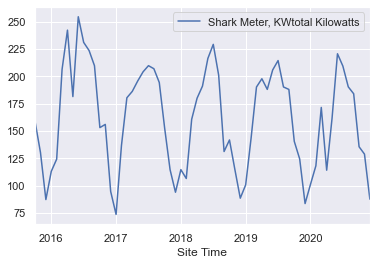

In [27]:
energy_monthly.plot();

In [28]:
#Get best parameters from auto_arima

stepwise_fit = auto_arima(energy_monthly, 
                            m=12,
                            seasonal=True,
                            trace=True,
                            maxiter = 10,
                      #      error_action='ignore',   # we don't want to know if an order does not work
                            suppress_warnings=False,  # we don't want convergence warnings
                            stepwise=True)           # set to stepwise

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=665.090, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=666.096, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=610.427, Time=0.08 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=621.292, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=826.499, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=624.597, Time=0.03 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=610.606, Time=0.13 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=649.186, Time=0.06 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=616.379, Time=0.05 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=631.320, Time=0.17 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=665.940, Time=0.04 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=613.772, Time=0.09 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=613.181, Time=0.07 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=639.060, Time=0.05 sec
 ARIMA(2,0,1)(1,0,0)[12] intercep

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   63
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 12)   Log Likelihood                -301.214
Date:                            Thu, 04 Feb 2021   AIC                            610.427
Time:                                    11:58:45   BIC                            619.000
Sample:                                         0   HQIC                           613.799
                                             - 63                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     43.4748     20.076      2.165      0.030       4.126      82.824
ar.L1          0.4090      0.207      1.976      0.048       0.003       0.815
ar.S.L12       0.5585      0.164      3.396      0.001       0.236       0.881
sigma2      1084.3901    279.739      3.876      0.000     536.112    1632.668
===================================================================================
Ljung-Box (Q):                       66.65   Jarque-Bera (JB):                 0.00
Prob(Q):                              0.01   Prob(JB):                         1.00
Heteroskedasticity (H):               0.55   Skew:                             0.00
Prob(H) (two-sided):                  0.18   Kurtosis:                         3.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
energy_weekly = energy_hourly_rolling_7D.resample('W').mean()

In [30]:
energy_weekly.shape

(275, 1)

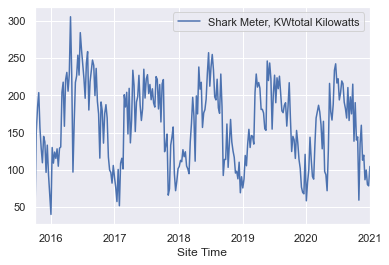

In [32]:
energy_weekly.plot();

In [ ]:
#Get best parameters from auto_arima

stepwise_fit = auto_arima(energy_weekly, 
                            m=52,
                            seasonal=True,
                            trace=True,
                            maxiter = 10,
                      #      error_action='ignore',   # we don't want to know if an order does not work
                            suppress_warnings=False,  # we don't want convergence warnings
                            stepwise=True)           # set to stepwise

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=inf, Time=2.25 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=2975.021, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=2748.988, Time=1.57 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=2816.477, Time=1.07 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=3607.474, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=2750.847, Time=0.07 sec
 ARIMA(1,0,0)(2,0,0)[52] intercept   : AIC=2750.049, Time=7.01 sec
 ARIMA(1,0,0)(1,0,1)[52] intercept   : AIC=inf, Time=1.69 sec
 ARIMA(1,0,0)(0,0,1)[52] intercept   : AIC=2749.452, Time=1.45 sec
 ARIMA(1,0,0)(2,0,1)[52] intercept   : AIC=2761.723, Time=7.08 sec
 ARIMA(0,0,0)(1,0,0)[52] intercept   : AIC=2969.753, Time=0.91 sec
 ARIMA(2,0,0)(1,0,0)[52] intercept   : AIC=2745.263, Time=1.90 sec
 ARIMA(2,0,0)(0,0,0)[52] intercept   : AIC=2745.976, Time=0.08 sec
 ARIMA(2,0,0)(2,0,0)[52] intercept   : AIC=2747.513, Time=6.57 sec
 ARIMA(2,0,0)(1,0,1)[52] inte